In [1]:
#ignoring warnings
import warnings
warnings.simplefilter('ignore')

#importing neccesary modules
import sys
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
from dateutil.parser import parse
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import time
from datetime import datetime, timezone
from dateutil import parser
import oandapyV20.endpoints.instruments as instruments
import configparser
import json
from oandapyV20 import API
import oandapyV20.endpoints.positions as positions
import oandapyV20.endpoints.trades as trades
from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.accounts as accounts
from oandapyV20.contrib.factories import InstrumentsCandlesFactory
from oandapyV20.contrib.requests import MarketOrderRequest, TrailingStopLossDetails
from oandapyV20.exceptions import V20Error, StreamTerminated
import sqlite3
from collections import OrderedDict, ChainMap

In [2]:
#https://oanda-api-v20.readthedocs.io/en/latest/index.html
config = configparser.ConfigParser()
config.read('oanda_new.cfg')

client = API(access_token=config['oanda']['access_token'])

In [3]:
def get_data(_from, _to, granularity, instrument, save_csv=False):
    """
        Collect historical data for training
        _from="2018-01-01 00:00"    date and time to start collecting candles
        _to=""                      date and time to end the collection of candles, if "", then end will be now.
        save_csv if True will save csv file in current folder
    """
    if _to == "":
        _to = datetime.strptime(datetime.now().isoformat()[0:19] + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ')
    else:
        _to = datetime.strptime(parser.parse(_to).isoformat() + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ')
    params = {
    "granularity": granularity,
    "from": datetime.strptime(parser.parse(_from).isoformat() + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ'),
    "to": _to
    }
    
    df = pd.DataFrame(columns=["Date", 'Open', 'High', 'Low', 'Close', "Volume"])
    for r in InstrumentsCandlesFactory(instrument=instrument, params=params):
        rv = client.request(r)

        results = [{"Date":candle['time'][0:19], "Open":float(candle['mid']['o']),
                    "High":float(candle['mid']['h']), "Low":float(candle['mid']['l']),
                   "Close":float(candle['mid']['c']), "Volume": float(candle['volume'])
                   } for candle in r.response.get('candles')]
        df = df.append(pd.DataFrame(results), ignore_index=True)
    
    df.set_index("Date", inplace=True)
    if save_csv:
        df.to_csv(instrument + "_" + granularity + ".csv")
    return df

In [4]:
start = "2020-04-05 00:00"    #date and time to start collecting candles
end = ""    #date and time to end the collection of candles, if "", then end will be now.
granularity = "H1"
instrument = "XAU_USD"


df1 = get_data(_from=start, _to=end, granularity=granularity, instrument=instrument, save_csv=False)
date_ori = pd.to_datetime(df1.iloc[:, 0]).tolist() 
df1.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2021-10-06T17:00:00,1762.530,1763.825,1760.475,1762.106,1511.0
2021-10-06T18:00:00,1762.156,1764.595,1761.830,1763.616,1151.0
2021-10-06T19:00:00,1763.570,1765.070,1763.475,1764.450,770.0
2021-10-06T20:00:00,1764.506,1764.810,1762.578,1762.825,350.0
2021-10-06T22:00:00,1762.990,1763.535,1762.650,1763.420,174.0


In [5]:
df1.rename(columns={'Close':'Closedf1'}, inplace=True)

In [6]:
start = "2020-04-05 00:00"    #date and time to start collecting candles
end = ""    #date and time to end the collection of candles, if "", then end will be now.
granularity = "H1"
instrument = "XAU_CAD"

df2 = get_data(_from=start, _to=end, granularity=granularity, instrument=instrument, save_csv=False)
date_ori = pd.to_datetime(df2.iloc[:, 0]).tolist() 
df2.tail()
df2.rename(columns={'Close':'Closedf2'}, inplace=True)

In [7]:
df_concat = pd.concat([df1.iloc[:, 3:4], df2.iloc[:, 3:4]], axis=1)
df_concat=df_concat.dropna()

In [8]:
df_concat.reset_index()

,Date,Closedf1,Closedf2
0,2020-04-05T22:00:00,1615.454,2300.777
1,2020-04-05T23:00:00,1619.942,2309.080
2,2020-04-06T00:00:00,1618.720,2300.316
3,2020-04-06T01:00:00,1619.827,2299.806
4,2020-04-06T02:00:00,1619.935,2301.086
...,...,...,...
8902,2021-10-06T17:00:00,1762.106,2219.064
8903,2021-10-06T18:00:00,1763.616,2220.754
8904,2021-10-06T19:00:00,1764.450,2221.240
8905,2021-10-06T20:00:00,1762.825,2219.670


In [9]:
print(df_concat)

                     Closedf1  Closedf2
Date                                   
2020-04-05T22:00:00  1615.454  2300.777
2020-04-05T23:00:00  1619.942  2309.080
2020-04-06T00:00:00  1618.720  2300.316
2020-04-06T01:00:00  1619.827  2299.806
2020-04-06T02:00:00  1619.935  2301.086
...                       ...       ...
2021-10-06T17:00:00  1762.106  2219.064
2021-10-06T18:00:00  1763.616  2220.754
2021-10-06T19:00:00  1764.450  2221.240
2021-10-06T20:00:00  1762.825  2219.670
2021-10-06T22:00:00  1763.420  2219.634

[8907 rows x 2 columns]


<AxesSubplot:xlabel='Date'>

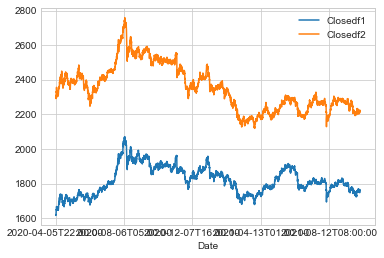

In [10]:
df_concat.plot()

In [11]:
def get_resids(d):
  pca = PCA(1).fit(d.T)
  index=pca.components_[0]
  mm = [sm.OLS(s, index).fit() for s in d.T]
  return list(map(lambda x: x.resid, mm))

def Zscore(X):
    return np.array((X - np.mean(X)) / np.std(X))

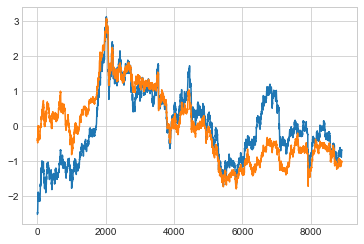

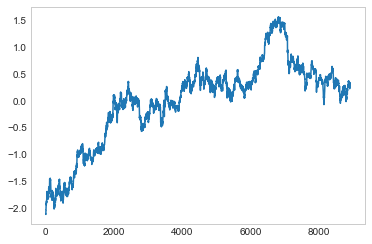

In [12]:
instrument1 = df_concat['Closedf1']
instrument2 = df_concat['Closedf2']
plt.plot(Zscore(instrument1))
plt.plot(Zscore(instrument2))

plt.show()

plt.plot(Zscore(instrument1)-Zscore(instrument2))
plt.grid()

In [13]:
from sklearn.decomposition import PCA

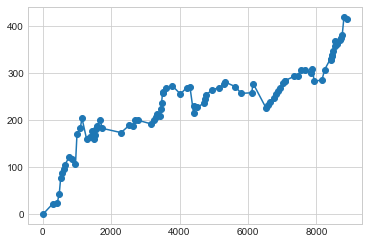

In [14]:
def backtest(instrument1,instrument2,th):
  inpos = 0
  inposlist = [0]
  lkbk = 200
  pnls = [0]
  idxs = [0]
  signallist = [0]

  for i in range(len(instrument1)):
    # GET DATA FROM MARKET
    if i<lkbk:
      continue

    za = Zscore(instrument1[i-lkbk:i])
    zn = Zscore(instrument2[i-lkbk:i])

    signal = za[-1] - zn[-1]
    if not inpos:
      pca = PCA(1).fit(np.array([instrument1[i-lkbk:i],instrument2[i-lkbk:i]]).T)
      hedge_ratio = pca.components_[0,1]/pca.components_[0,0]
      
    
    if inpos==0 and signal<-th:
      entry = instrument1[i]*hedge_ratio - instrument2[i] 
      # SEND ENTRY ORDERS TO MARKET
      inpos = 1
      inposlist.append(inpos)
      signallist.append(signal)

    elif inpos>0 and signal>0:
      pnl =  (instrument1[i]*hedge_ratio - instrument2[i]) - entry
      inpos = 0
      pnls.append(pnl)
      idxs.append(i)
      inposlist.append(inpos)
      signallist.append(signal)    

    if inpos==0 and signal>th:
      entry =  instrument1[i]*hedge_ratio - instrument2[i]
      inpos = -1
      inposlist.append(inpos)
      signallist.append(signal)

    elif inpos<0 and signal<0:
      pnl = entry - (instrument1[i]*hedge_ratio - instrument2[i])
      inpos = 0
      pnls.append(pnl)
      idxs.append(i)
      inposlist.append(inpos)
      signallist.append(signal)

  return idxs,pnls, inposlist, signallist

idxs,pnls, inposlist, signallist = backtest(instrument1,instrument2,0.6)
plt.plot(idxs,np.cumsum(pnls),'-o');


In [15]:
inposlist[-1]

-1

In [16]:
if inposlist[-1] == 1:
    print("LONG A, SHORT B")
    
elif inposlist[-1] == -1:
    print("SHORT A, LONG B")
    
elif inposlist[-1] == 0:
    print("Do nothing right now!")

SHORT A, LONG B


In [17]:
signallist[-1]

0.635327543086057

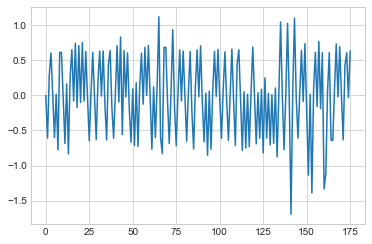

In [18]:
plt.plot(signallist)
plt.show()